<a href="https://colab.research.google.com/github/artemisIsNotBeam/mewing-Ai/blob/main/mewing_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics
!pip install tensorflow
!pip install torch
!pip install torchvision
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.7/780.7 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import torch
from ultralytics import YOLO

#model = torch.load('/content/drive/MyDrive/mewingAI/best.pt')
model = YOLO('/content/drive/MyDrive/mewingAI/best.pt')
#model.load('/content/drive/MyDrive/mewingAI/best.pt')

Prediction
https://docs.ultralytics.com/modes/predict/#inference-arguments

In [59]:
def predict(path):
  results = model(path)
  result = results[0]
  boxes = result.boxes  # Boxes object for bounding box outputs
  masks = result.masks  # Masks object for segmentation masks outputs
  keypoints = result.keypoints  # Keypoints object for pose outputs
  probs = result.probs  # Probs object for classification outputs
  obb = result.obb  # Oriented boxes object for OBB outputs
  result.show()  # display to screen


  result.save(filename="result.jpg")  # save to disk
  return result.tojson(normalize=True)
  #return probs
#thing = predict("/content/drive/MyDrive/mewingAI/datasets/FacialFeatures_split/test/images/00a0fd8177a1db74_jpg.rf.e66cca8cc8cccf937b160ea6546b1fbb.jpg")

In [5]:
import numpy as np
import cv2

def preprocess_input(image_pil, net_h=416, net_w=416):
    image = np.asarray(image_pil)
    new_h, new_w, _ = image.shape
    # print("net:", net_h, net_w)
    # print("old:",new_h, new_w)
    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h
    new_w = int(new_w)
    new_h = int(new_h)
    # print("new:",int(new_h), int(new_w))
    # resize the image to the new size
    #resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))
    resized = cv2.resize(image/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    # print("dims:",int((net_h-new_h)//2), int((net_h+new_h)//2), int((net_w-new_w)//2), int((net_w+new_w)//2))
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)
    # print(new_image.shape)


    return new_image

Display image

In [6]:
def processImg(path):
  from PIL import Image
  from matplotlib import  pyplot as plt

  image_path = path
  image_pil = Image.open(image_path)
  image_w, image_h = image_pil.size
  new_image = preprocess_input(image_pil, 640, 640)

  new_image_pil = Image.fromarray((new_image[0] * 255).astype('uint8'))
  #new_image_pil.save("/content/new_img.jpg")

  plt.imshow(new_image[0])
  plt.show()

  return new_image_pil

In [11]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [76]:
import json

def readOutput(vals):
  jsonVals=json.loads(vals)
  names = []
  confidence=[]
  for item in jsonVals:
    #print(item)
    names.append(item['name'])
    confidence.append(item['confidence'])
  print(names)
  print(confidence)

  if ('openmouth' in names) and ('closedmouth' in names):
    openIndex=names.index('openmouth')
    closedIndex=names.index('closedmouth')
    if confidence[openIndex]>confidence[closedIndex]:
      return 'open'
    else:
      return 'closed'
  elif 'openmouth' in names:
    return 'open'
  else:
    return 'closed'

result = readOutput(someJson)

['face', 'openeye', 'openeye', 'openmouth', 'openeye', 'closedmouth']
[0.87001, 0.48166, 0.47647, 0.36687, 0.32886, 0.25586]


<IPython.core.display.Javascript object>

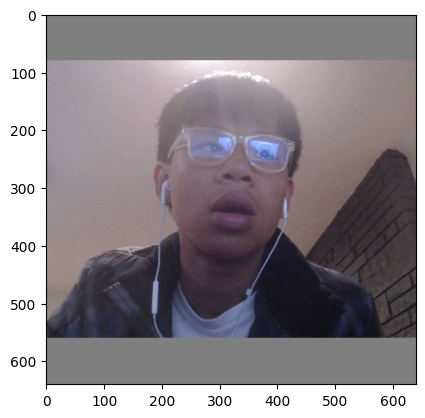


0: 640x640 1 face, 2 openeyes, 1 openmouth, 217.4ms
Speed: 2.9ms preprocess, 217.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
['face', 'openeye', 'openmouth', 'openeye']
[0.88225, 0.52926, 0.49555, 0.38771]


'open'

In [79]:
def getresults(img):
  test = processImg(img)
  someJson = predict(test)
  result = readOutput(someJson)
  return result

getresults(take_photo())